In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 788M/788M [00:13<00:00, 59.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [ ]:


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50,InceptionV3,DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Precision,Recall,F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import shutil
import random
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def check_image_files(directory):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif']
    for root, dirs, files in os.walk(directory):
        for file in files:
            if not any(file.endswith(ext) for ext in valid_extensions):
                print(f"Non-image file found: {file}")

check_image_files('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages')

Non-image file found: Thumbs.db
Non-image file found: Thumbs.db


In [ ]:
def remove_non_image_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == 'Thumbs.db':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed non-image file: {file_path}")

remove_non_image_files('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages')

Removed non-image file: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/Thumbs.db
Removed non-image file: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/Thumbs.db


In [ ]:
from tensorflow.keras.preprocessing import image
import os

def validate_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = image.load_img(file_path)
                img.verify()  # Verifies if the file is an image
            except (IOError, SyntaxError) as e:
                print(f"File {file} is not a valid image.")

validate_images('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages')

File 666.jpg is not a valid image.


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


File 11702.jpg is not a valid image.


In [ ]:
from PIL import Image
import os

def remove_invalid_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('jpg', 'jpeg', 'png')):  # Check if the file is an image
                try:
                    # Try opening the image file
                    img = Image.open(file_path)
                    img.verify()  # Verify if it is a valid image
                except (IOError, SyntaxError) as e:
                    # If the file is invalid, remove it
                    print(f"Removing invalid image: {file_path}")
                    os.remove(file_path)

# Remove invalid images from train and test directories
remove_invalid_images('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog')


Removing invalid image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg


In [ ]:
import os

try:
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs')
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/cats')
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/dogs')
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/cats')
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/dogs')
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test/cats')
    os.makedirs('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test/dogs')
    print("Directories created successfully!")
except OSError as e:
    print(f"Error: {e}")


Directories created successfully!


In [ ]:
#Define data path
CAT_DIR = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat'
DOG_DIR = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog'

TRAINING_DIR = "/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/"
VALIDATION_DIR = "/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

INCLUDE_TEST = True

# Function to split and images

In [ ]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.8, random_seed=42):
    # Get the list of all files in the main directory
    all_files = [file for file in os.listdir(main_dir) if os.path.getsize(os.path.join(main_dir, file)) > 0]

    # Split the data into training and (validation + test) sets
    train_files, remaining_files = train_test_split(all_files, train_size=split_size, random_state=random_seed)

    # Split the remaining data into validation and test sets if include_test_split is True
    if include_test_split:
        validation_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=random_seed)
    else:
        validation_files, test_files = remaining_files, []

    # Copy files to their respective directories
    copy_files(main_dir, training_dir, train_files)
    copy_files(main_dir, validation_dir, validation_files)
    if include_test_split:
        copy_files(main_dir, test_dir, test_files)

    print("Split successful!")

def copy_files(source_dir, destination_dir, file_list):
    # Create destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # Copy files from source to destination
    for file in file_list:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        shutil.copyfile(source_path, destination_path)

In [ ]:
split_data(CAT_DIR, '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/cats', '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/cats', '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test/cats',INCLUDE_TEST, 0.8)
split_data(DOG_DIR, '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/dogs', '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/dogs','/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.8)

Split successful!
Split successful!


In [ ]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)
train_generator = train_gen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test',
        target_size=(150, 150),
        batch_size=32,
        shuffle= False,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
trcatpath='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/cats'
trdogpath='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training/dogs'
valcatpath='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/cats'
valdogpath='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/validation/dogs'
testcatpath='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test/cats'
testdogpath='/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/test/dogs'

In [ ]:
print(len(os.listdir(trcatpath)))
print(len(os.listdir(trdogpath)))

print(len(os.listdir(valcatpath)))
print(len(os.listdir(valdogpath)))


print(len(os.listdir(testcatpath)))
print(len(os.listdir(testdogpath)))

9999
9999
1250
1250
1250
1250


In [ ]:
model =Sequential ()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,836,673 (18.45 MB)

 Trainable params: 4,836,673 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam




#from keras.optimizers import Adam
#opt = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])
result = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 88ms/step - accuracy: 0.5983 - loss: 0.6490 - val_accuracy: 0.7632 - val_loss: 0.5011
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 71ms/step - accuracy: 0.7571 - loss: 0.5014 - val_accuracy: 0.7904 - val_loss: 0.4625
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8155 - loss: 0.4067 - val_accuracy: 0.8024 - val_loss: 0.4181
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.8579 - loss: 0.3320 - val_accuracy: 0.8208 - val_loss: 0.4104
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.8943 - loss: 0.2537 - val_accuracy: 0.8344 - val_loss: 0.4397
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.9383 - loss: 0.1563 - val_accuracy: 0.8328 - val_loss: 0.4797
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.9600 - loss: 0.1043 - val_accuracy: 0.8260 - val_loss: 0.6945
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - accuracy: 0.9765 - loss: 0.0646 - val_accurac

In [ ]:
if INCLUDE_TEST:
    score, acc = model.evaluate(test_generator)
    print('Test lose:', score)
    print('Test accuracy:', acc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8344 - loss: 0.8853
Test lose: 0.9340740442276001
Test accuracy: 0.8208000063896179


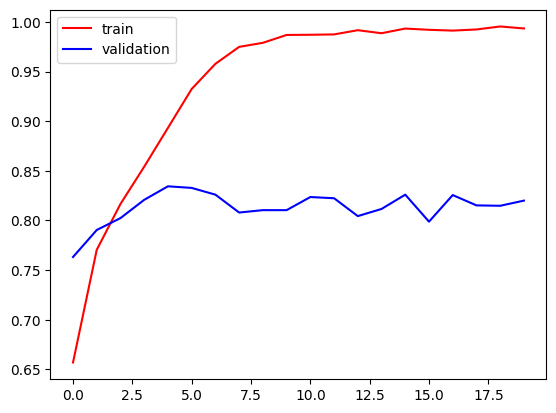

In [ ]:
plt.plot(result.history['accuracy'],color='red',label='train')
plt.plot(result.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

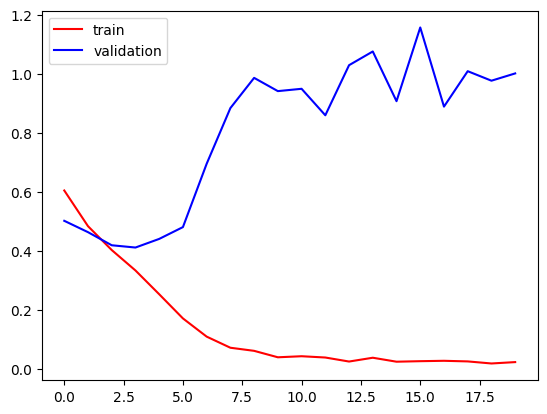

In [ ]:
plt.plot(result.history['loss'],color='red',label='train')
plt.plot(result.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# CNN Model After Solve Overfitting

In [ ]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Block 1
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Block 2
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Block 3
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Fully Connected layers
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(Dropout(0.2))

# Output layer
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      12,846,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 13,241,537 (50.51 MB)

 Trainable params: 13,238,529 (50.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

**Methods for solving Overfitting**

In [ ]:
train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        channel_shift_range=20)
train_generator = train_gen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

early_stoping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Found 19998 images belonging to 2 classes.


In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(),Recall()])

result2 = model2.fit(
        train_generator,
        callbacks=[early_stoping,learning_rate_reduction],
        epochs=20,
        validation_data=validation_generator,
        shuffle=True)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 251ms/step - accuracy: 0.5939 - loss: 0.8683 - precision: 0.5964 - recall: 0.5932 - val_accuracy: 0.5712 - val_loss: 1.1493 - val_precision: 0.8532 - val_recall: 0.1720 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 232ms/step - accuracy: 0.6808 - loss: 0.5971 - precision: 0.6876 - recall: 0.6669 - val_accuracy: 0.7256 - val_loss: 0.5508 - val_precision: 0.8161 - val_recall: 0.5824 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 233ms/step - accuracy: 0.7186 - loss: 0.5545 - precision: 0.7195 - recall: 0.7048 - val_accuracy: 0.6824 - val_loss: 0.6140 - val_precision: 0.6258 - val_recall: 0.9072 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 230ms/step - accuracy: 0.7451 - loss: 0.5148 - precision: 0.7470 - recall: 0.7402 - val_accuracy: 0.6208 - val_loss: 1.0961 - val_precision: 0.9081 - val_recall: 0.2688 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 234

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9238 - loss: 0.1977 - precision: 0.4154 - recall: 0.4677
Test Loss: 0.20687235891819
Test Accuracy: 0.9204000234603882
Test Precision: 0.9275833964347839
Test Recall: 0.9120000004768372
Test F1-Score: 0.9197256937750796
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


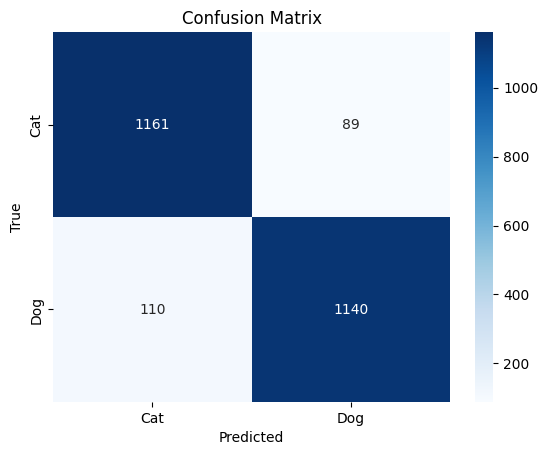

In [ ]:
import numpy as np

if INCLUDE_TEST:
    score, acc, pre, rcl = model2.evaluate(test_generator)
    f1=2*((pre*rcl)/(pre+rcl))
    print("===============")
    print('Test Loss:', score)
    print('Test Accuracy:', acc)
    print('Test Precision:',pre)
    print('Test Recall:',rcl)
    print('Test F1-Score:',f1)
    print("===============")
    print("===============")
    # Generate predictions for the test set using the evaluation generator
    predictions = model2.predict(test_generator)

    # Convert probabilities to binary predictions
    binary_predictions = np.round(predictions)

    # Get true labels
    true_labels = test_generator.classes

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


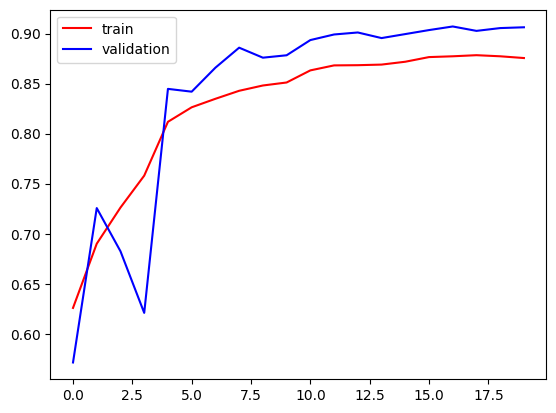

In [ ]:
plt.plot(result2.history['accuracy'],color='red',label='train')
plt.plot(result2.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

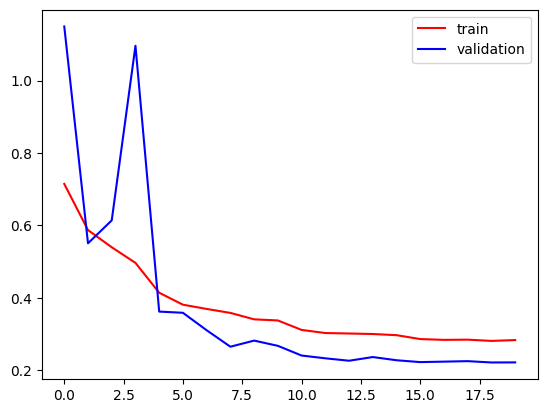

In [ ]:
plt.plot(result2.history['loss'],color='red',label='train')
plt.plot(result2.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
class_names = ['Cat', 'Dog']

def plot_prediction(generator, n_images):
    # Fetch a batch of images and labels from the generator
    images, labels = next(generator)  # Fixed here

    # Get the model predictions
    preds = model2.predict(images)
    threshold = 0.5
    predictions = (preds > threshold).astype(int)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for i, (image, label, pred) in enumerate(zip(images, labels, preds), 1):
        plt.subplot(4, 3, i)
        plt.imshow(image)

        # Set title color based on prediction correctness
        title_color = 'g' if predictions[i - 1] == label else 'r'
        title = f"{class_names[label]}: {class_names[predictions[i - 1][0]]}"
        title_obj = plt.title(title)
        plt.setp(title_obj, color=title_color)

        plt.axis('off')

        if i == n_images:
            break

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


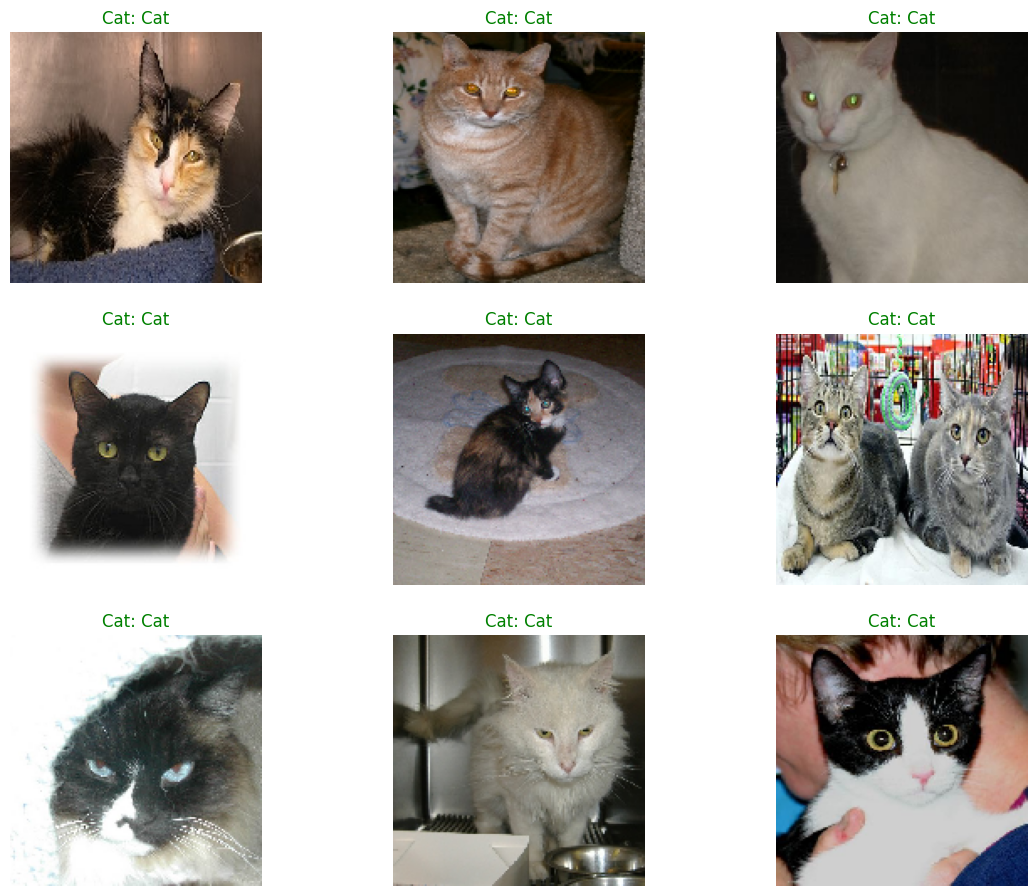

In [ ]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 9)

In [ ]:
model.save('cat_dog_classifier.h5')  # Save the model to a file


# DenseNet121 Model

In [ ]:
base_model  = DenseNet121(weights='imagenet',
                    include_top=False,
                    input_shape=(150,150,3)
                   )
base_model = models.Model(inputs=base_model.inputs, outputs=base_model.output)

model4 = models.Sequential()
model4.add(base_model)
model4.add(layers.Flatten())
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(2048, activation='relu'))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(1, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False


model4.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_33 (Functional)           │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2048)                │      33,556,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,661,569 (155.11 MB)

 Trainable params: 33,591,297 (128.14 MB)

 Non-trainable params: 7,070,272 (26.97 MB)

In [ ]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])
result4 = model4.fit(
        train_generator,
        epochs=20,
        callbacks=[early_stoping,learning_rate_reduction],
        validation_data=validation_generator,
        shuffle=True)

Epoch 1/20
552/625 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.9491 - loss: 0.1323 - precision_3: 0.9522 - recall_3: 0.9471

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 277ms/step - accuracy: 0.9486 - loss: 0.1342 - precision_3: 0.9516 - recall_3: 0.9466 - val_accuracy: 0.9748 - val_loss: 0.0632 - val_precision_3: 0.9790 - val_recall_3: 0.9704 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 248ms/step - accuracy: 0.9483 - loss: 0.1298 - precision_3: 0.9524 - recall_3: 0.9451 - val_accuracy: 0.9752 - val_loss: 0.0649 - val_precision_3: 0.9677 - val_recall_3: 0.9832 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 247ms/step - accuracy: 0.9492 - loss: 0.1273 - precision_3: 0.9522 - recall_3: 0.9477 - val_accuracy: 0.9740 - val_loss: 0.0785 - val_precision_3: 0.9625 - val_recall_3: 0.9864 - learning_rate: 0.0010


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9677 - loss: 0.0913 - precision_1: 0.4655 - recall_1: 0.5036
Test Loss: 0.06444919854402542
Test Accuracy: 0.9783999919891357
Test Precision: 0.9716088175773621
Test Recall: 0.9855999946594238
Test F1-Score: 0.9785543979039097
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step


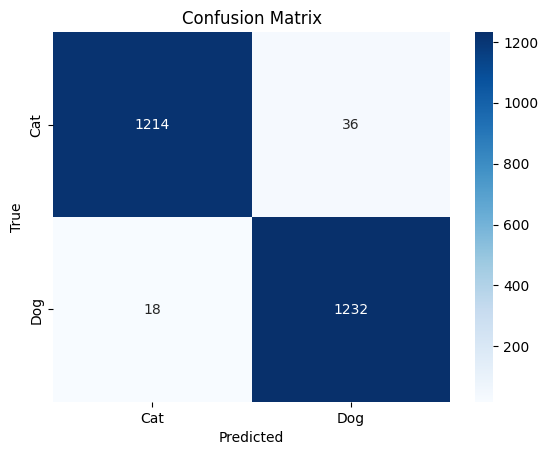

In [ ]:
if INCLUDE_TEST:
    score, acc, pre, rcl  = model4.evaluate(test_generator)
    f1=2*((pre*rcl)/(pre+rcl))
    print('Test Loss:', score)
    print('Test Accuracy:', acc)
    print('Test Precision:',pre)
    print('Test Recall:',rcl)
    print('Test F1-Score:',f1)
    # Generate predictions for the test set using the evaluation generator
    predictions = model4.predict(test_generator)

    # Convert probabilities to binary predictions
    binary_predictions = np.round(predictions)

    # Get true labels
    true_labels = test_generator.classes

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

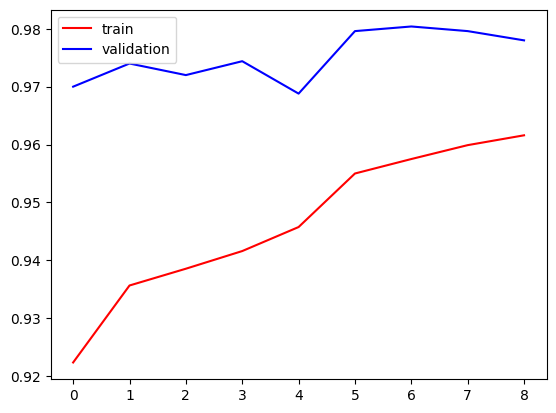

In [ ]:
plt.plot(result4.history['accuracy'],color='red',label='train')
plt.plot(result4.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

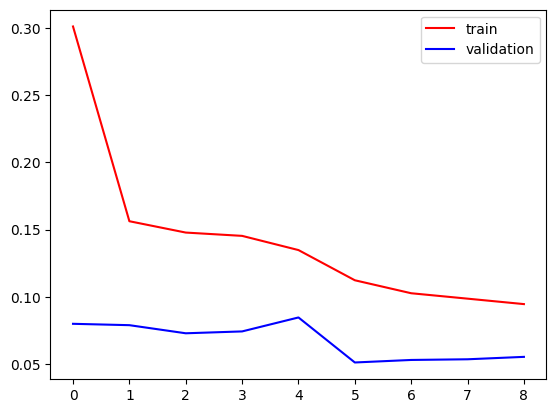

In [ ]:
plt.plot(result4.history['loss'],color='red',label='train')
plt.plot(result4.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
class_names = ['Cat', 'Dog']

def plot_prediction_with_prob(generator, n_images):
    # Get the images and the labels from the generator
    images, labels = next(generator)  #


    # Gets the model predictions
    preds = model4.predict(images)
    threshold = 0.5
    predictions = (preds > threshold).astype(int)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for i, (image, label, pred) in enumerate(zip(images, labels, preds), 1):
        plt.subplot(4, 3, i)
        plt.imshow(image)

        title_color = 'g' if predictions[i - 1] == label else 'r'
        title = f"{class_names[label]}: "
        title_obj = plt.title(title)
        plt.setp(title_obj, color=title_color)

        plt.axis('off')

        if i == n_images:
            break

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


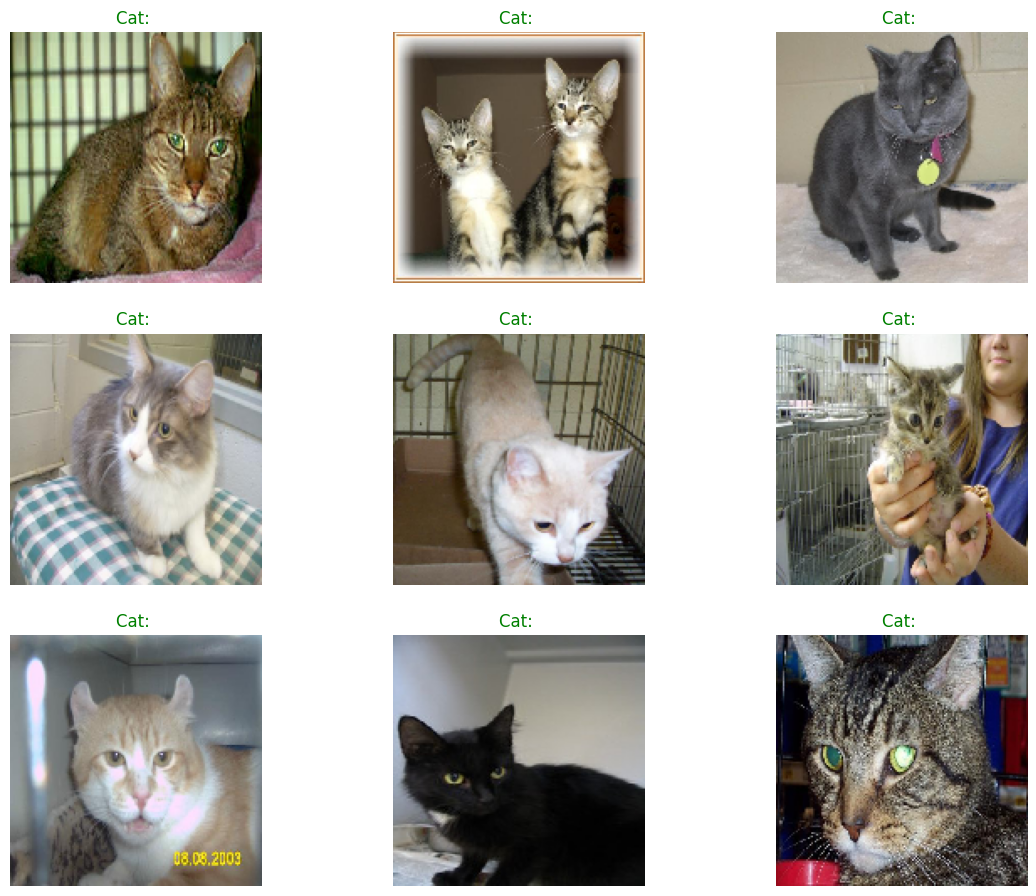

In [ ]:
if INCLUDE_TEST:
    plot_prediction_with_prob(test_generator, 9)

Vgg MOdel

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layer (classification head)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional layers of VGG16 (optional for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Create the full model by adding a new classification head (fully connected layers)
model_vgg16 = models.Sequential()

# Add the VGG16 base model
model_vgg16.add(base_model)

# Add the custom top layers
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.BatchNormalization())  # optional, helps with training stability
model_vgg16.add(layers.Dense(1024, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))  # Dropout to reduce overfitting
model_vgg16.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Display the model summary
model_vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,138,113 (88.26 MB)

 Trainable params: 8,407,041 (32.07 MB)

 Non-trainable params: 14,731,072 (56.19 MB)

In [ ]:
model_vgg16.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', Precision(), Recall()])


In [ ]:
result_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stoping, learning_rate_reduction],  # Optional callbacks for better performance
    shuffle=True
)


Epoch 1/20
 91/625 ━━━━━━━━━━━━━━━━━━━━ 2:11 247ms/step - accuracy: 0.7239 - loss: 1.2263 - precision_2: 0.7189 - recall_2: 0.7282

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 273ms/step - accuracy: 0.7779 - loss: 0.9016 - precision_2: 0.7782 - recall_2: 0.7731 - val_accuracy: 0.8980 - val_loss: 0.2719 - val_precision_2: 0.8977 - val_recall_2: 0.8984 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 259ms/step - accuracy: 0.8345 - loss: 0.3762 - precision_2: 0.8425 - recall_2: 0.8204 - val_accuracy: 0.9068 - val_loss: 0.2419 - val_precision_2: 0.9013 - val_recall_2: 0.9136 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 267ms/step - accuracy: 0.8519 - loss: 0.3441 - precision_2: 0.8621 - recall_2: 0.8425 - val_accuracy: 0.9068 - val_loss: 0.2283 - val_precision_2: 0.9313 - val_recall_2: 0.8784 - learning_rate: 0.0010


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8921 - loss: 0.3039 - precision_2: 0.3859 - recall_2: 0.4625
Test Loss: 0.2796614468097687
Test Accuracy: 0.8935999870300293
Test Precision: 0.8942307829856873
Test Recall: 0.892799973487854
Test F1-Score: 0.8935148054386216
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step


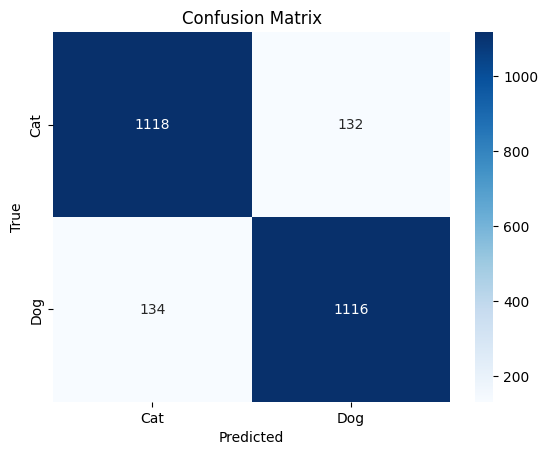

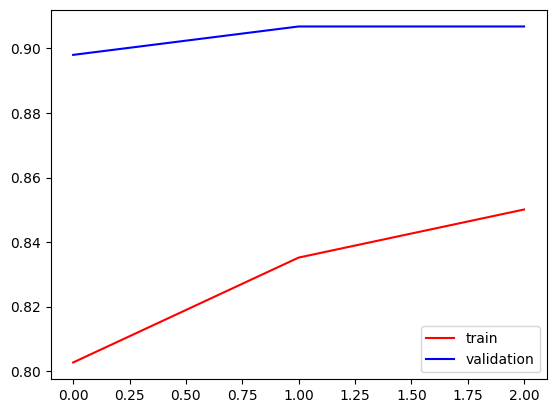

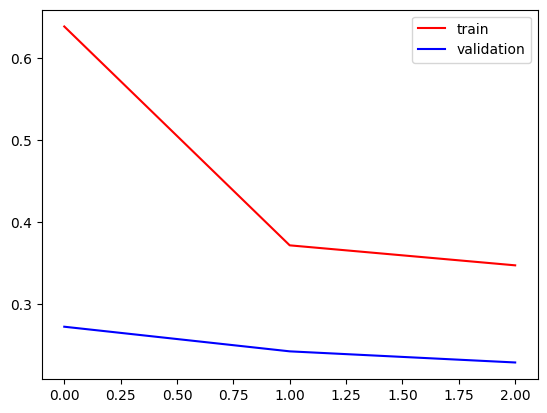

In [ ]:
if INCLUDE_TEST:
    score, acc, pre, rcl = model_vgg16.evaluate(test_generator)
    f1 = 2 * ((pre * rcl) / (pre + rcl))
    print('Test Loss:', score)
    print('Test Accuracy:', acc)
    print('Test Precision:', pre)
    print('Test Recall:', rcl)
    print('Test F1-Score:', f1)
    print("===============")

    # Generate predictions and plot confusion matrix
    predictions = model_vgg16.predict(test_generator)
    binary_predictions = np.round(predictions)
    true_labels = test_generator.classes
    conf_matrix = confusion_matrix(true_labels, binary_predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot accuracy and loss graphs
plt.plot(result_vgg16.history['accuracy'], color='red', label='train')
plt.plot(result_vgg16.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

plt.plot(result_vgg16.history['loss'], color='red', label='train')
plt.plot(result_vgg16.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()
